# **Memprediksi Churn Nasabah Bank**

## **Import Libraries**

In [1]:
pip install seaborn --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from imblearn.under_sampling import TomekLinks
import random
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

## **Load data**

In [3]:
df = pd.read_csv('/content/BankChurners.csv')
df

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.999910
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.999940
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.999980
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.999870
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.999980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,...,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,0.000191,0.999810
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,...,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,0.995270,0.004729
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,...,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,0.997880,0.002118
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,0.996710,0.003294


In [4]:
y = pd.Series(np.where(df['Attrition_Flag'] == 'Attrited Customer', 1, 0), df.index)
#Menambahkan kolom y ke dalam tabel
df.insert(0,'y', pd.Series(np.where(df['Attrition_Flag'] == 'Attrited Customer', 1, 0), df.index))

In [5]:
#Menghapus dua kolom pertama yang tidak prediktif
df = df.drop(['Attrition_Flag','CLIENTNUM'],axis=1)
df = df.iloc[:,0:-2]

## **Exploratory Data Analysis**

### **Melihat Informasi Data**

In [6]:
df.shape

(10127, 20)

In [7]:
df.describe()

,y,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,0.160660,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,0.367235,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,0.000000,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,0.000000,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,0.000000,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,0.000000,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,1.000000,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   y                         10127 non-null  int64  
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

### **Plotting Data Hasil Import**

In [9]:
#correlation plot
df.corr()

,y,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
y,1.000000,0.018203,0.018991,0.013687,-0.150005,0.152449,0.204491,-0.023873,-0.263053,-0.000285,-0.131063,-0.168598,-0.371403,-0.290054,-0.178410
Customer_Age,0.018203,1.000000,-0.122254,0.788912,-0.010931,0.054361,-0.018452,0.002476,0.014780,0.001151,-0.062042,-0.046446,-0.067097,-0.012143,0.007114
Dependent_count,0.018991,-0.122254,1.000000,-0.103062,-0.039076,-0.010768,-0.040505,0.068065,-0.002688,0.068291,-0.035439,0.025046,0.049912,0.011087,-0.037135
Months_on_book,0.013687,0.788912,-0.103062,1.000000,-0.009203,0.074164,-0.010774,0.007507,0.008623,0.006732,-0.048959,-0.038591,-0.049819,-0.014072,-0.007541
Total_Relationship_Count,-0.150005,-0.010931,-0.039076,-0.009203,1.000000,-0.003675,0.055203,-0.071386,0.013726,-0.072601,0.050119,-0.347229,-0.241891,0.040831,0.067663
Months_Inactive_12_mon,0.152449,0.054361,-0.010768,0.074164,-0.003675,1.000000,0.029493,-0.020394,-0.042210,-0.016605,-0.032247,-0.036982,-0.042787,-0.038989,-0.007503
Contacts_Count_12_mon,0.204491,-0.018452,-0.040505,-0.010774,0.055203,0.029493,1.000000,0.020817,-0.053913,0.025646,-0.024445,-0.112774,-0.152213,-0.094997,-0.055471
Credit_Limit,-0.023873,0.002476,0.068065,0.007507,-0.071386,-0.020394,0.020817,1.000000,0.042493,0.995981,0.012813,0.171730,0.075927,-0.002020,-0.482965
Total_Revolving_Bal,-0.263053,0.014780,-0.002688,0.008623,0.013726,-0.042210,-0.053913,0.042493,1.000000,-0.047167,0.058174,0.064370,0.056060,0.089861,0.624022
Avg_Open_To_Buy,-0.000285,0.001151,0.068291,0.006732,-0.072601,-0.016605,0.025646,0.995981,-0.047167,1.000000,0.007595,0.165923,0.070885,-0.010076,-0.538808


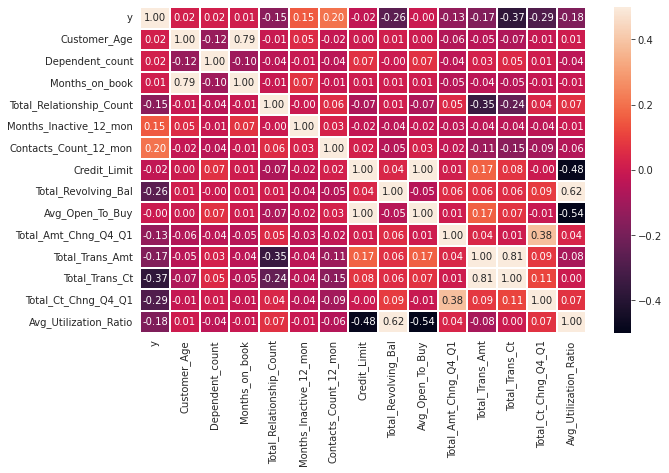

In [10]:
#correlation heatmap
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),annot=True,lw=1,robust=True,fmt='.2f',vmin=-0.5,vmax=0.5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  """Entry point for launching an IPython kernel.


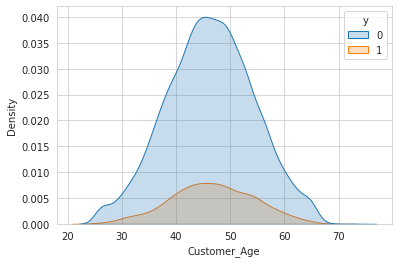

In [11]:
sns.kdeplot(x='Customer_Age',data=df, hue='y',shade=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  """Entry point for launching an IPython kernel.


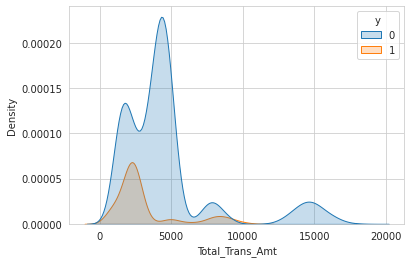

In [12]:
sns.kdeplot(x='Total_Trans_Amt',data=df, hue='y', shade=True)

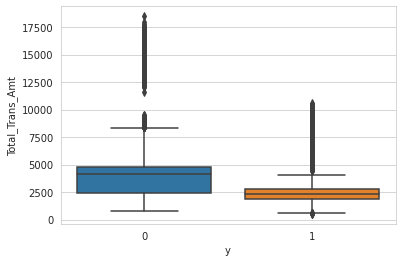

In [13]:
sns.boxplot(x='y',y='Total_Trans_Amt', data=df)

In [14]:
#rata-rata jumlah transaksi tahunan untuk churner dan non-churner
df.groupby('y').agg({'Total_Trans_Amt':np.average, 'Months_on_book':np.average})

,Total_Trans_Amt,Months_on_book
y,,
0,4654.655882,35.880588
1,3095.025814,36.178242


In [15]:
#Lifetime value of customer
p = 0.03 #profit margin, bank menghasilkan sekitar 3% per transaksi
ac = 3095 #total jumlah transaksi tahunan untuk churner
an = 4654
t = 3 #periode waktu retensi dalam tahun

# ltv = total annual transaction amount * margin per transaction * retention time period
churner_ltv = ac*p*t
nonchurner_ltv = an*p*t

print('churner ltv:',churner_ltv)
print('non churner ltv:',nonchurner_ltv)

churner ltv: 278.54999999999995
non churner ltv: 418.86


## **Data Preprocessing**

In [16]:
df.isnull().sum()

y                           0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

### **Missing Values**

Diketahui pada dataset ini tidak ada missing values. Kode di bawah ini adalah template untuk ***impute missing values***. Untuk fitur kategori dipilih imputasi *'most frequent'* dan untuk fitur numerik dipilih *'median'*.

In [17]:
#impute pada kolom kategorikal
from sklearn.impute import SimpleImputer

categorical_features = df.select_dtypes(include=['object']).columns
cat = SimpleImputer(strategy='most_frequent',copy=False)
cat1 = cat.fit(df[categorical_features].astype(str))
df[categorical_features] = cat1.transform(df[categorical_features])

In [18]:
#impute pada kolom numerik
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
num = SimpleImputer(strategy='median',copy=False)
num1 = num.fit(df[numeric_features])
df[numeric_features] = num1.transform(df[numeric_features])

### **Categorical Features**

In [19]:
#Membuat kolom numerikal baru dan menghapus kolom sebelumnya
categorical_features = df.select_dtypes(include=['object']).columns
X = pd.get_dummies(df[categorical_features], prefix_sep='_')
X = pd.merge(df,X,how='outer',left_index=True,right_index=True)
X = X.drop(categorical_features, axis=1)
X.head()

,y,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,0.0,45.0,3.0,39.0,5.0,1.0,3.0,12691.0,777.0,11914.0,...,0,0,1,0,0,0,1,0,0,0
1,0.0,49.0,5.0,44.0,6.0,1.0,2.0,8256.0,864.0,7392.0,...,0,0,0,0,1,0,1,0,0,0
2,0.0,51.0,3.0,36.0,4.0,1.0,0.0,3418.0,0.0,3418.0,...,0,0,0,1,0,0,1,0,0,0
3,0.0,40.0,4.0,34.0,3.0,4.0,1.0,3313.0,2517.0,796.0,...,0,0,0,0,1,0,1,0,0,0
4,0.0,40.0,3.0,21.0,5.0,1.0,0.0,4716.0,0.0,4716.0,...,0,0,1,0,0,0,1,0,0,0


### **Feature Engineering**

In [20]:
!pip install featuretools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
import featuretools as ft

/usr/local/lib/python3.7/dist-packages/woodwork/__init__.py:23: FutureWarning: Woodwork may not support Python 3.7 in next non-bugfix release.
  "Woodwork may not support Python 3.7 in next non-bugfix release.", FutureWarning
/usr/local/lib/python3.7/dist-packages/featuretools/__init__.py:67: FutureWarning: Featuretools may not support Python 3.7 in next non-bugfix release.
  FutureWarning,


### **Normalization / Scaling**

In [22]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
index = X.columns

transformer = scaler.fit_transform(X)
X = pd.DataFrame(transformer, columns = index)
X.head()

,y,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,0.0,-0.090909,0.5,0.333333,0.5,-1.0,1.0,0.956476,-0.350175,0.988927,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.272727,1.5,0.888889,1.0,-1.0,0.0,0.435477,-0.289123,0.459078,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.454545,0.5,0.000000,0.0,-1.0,-2.0,-0.132863,-0.895439,-0.006562,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-0.545455,1.0,-0.222222,-0.5,2.0,-1.0,-0.145198,0.870877,-0.313785,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,-0.545455,0.5,-1.666667,0.5,-1.0,-2.0,0.019618,-0.895439,0.145527,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **Test-Train Split**

In [23]:
from sklearn.model_selection import train_test_split

X = X.drop(columns='y')
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 12)
x_train.shape

(7595, 37)

In [24]:
y.value_counts()

0    8500
1    1627
dtype: int64

In [25]:
#Menyeimbangkan training set
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12)
x_train, y_train = sm.fit_resample(x_train, y_train)
x_train.shape

(12720, 37)

## **Model Selection and Evaluation**

In [26]:
#function untuk mengevaluasi model
def eval_model(model):
    preds = model.predict(x_test)
    probs = model.predict_proba(x_test)
    auc_prob_val = roc_auc_score(y_test, probs[:,1])
    accuracy = accuracy_score(y_test, preds)
    print('AUC Score:', auc_prob_val,'\n','Accuracy:', accuracy)
    print('\n','Confusion Matrix','\n',confusion_matrix(y_test, preds))
    print('\n','Classification Report', '\n', classification_report(y_test, preds, digits=3))

### **Logistic Regression**

In [27]:
reg = LogisticRegression()

#hyperparameters
solvers = ['newton-cg','lbfgs','liblinear']
penalty = ['l1','l2']
c = [100,10,1,.1,.01]

#grid search
grid = dict(solver=solvers,penalty=penalty,C=c)
cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=reg,param_grid=grid,n_jobs=-1,cv=cv,scoring='f1',error_score=0)
fit = grid_search.fit(x_train,y_train)

eval_model(fit)

AUC Score: 0.921795727636849 
 Accuracy: 0.8550552922590837

 Confusion Matrix 
 [[1842  298]
 [  69  323]]

 Classification Report 
               precision    recall  f1-score   support

           0      0.964     0.861     0.909      2140
           1      0.520     0.824     0.638       392

    accuracy                          0.855      2532
   macro avg      0.742     0.842     0.774      2532
weighted avg      0.895     0.855     0.867      2532



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
300 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solve

### **Random Forest**

In [28]:
rf = RandomForestClassifier()

#hyperparameters
n_estimators = [10,100,1000]
max_features = ['sqrt','log2']

#grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=rf,param_grid=grid,n_jobs=-1,cv=cv,scoring='f1',error_score=0)
fit = grid_search.fit(x_train,y_train)

eval_model(fit)

AUC Score: 0.9881836496280755 
 Accuracy: 0.9597156398104265

 Confusion Matrix 
 [[2084   56]
 [  46  346]]

 Classification Report 
               precision    recall  f1-score   support

           0      0.978     0.974     0.976      2140
           1      0.861     0.883     0.872       392

    accuracy                          0.960      2532
   macro avg      0.920     0.928     0.924      2532
weighted avg      0.960     0.960     0.960      2532



### **XG Boost**

In [29]:
xgb = XGBClassifier()

#hyperparameters
eta = [.1,.4,.7,1]
min_child_weight = [3,6,10]
max_depth = [.1,1,5,10]

#grid search
grid = dict(eta=eta,min_child_weight=min_child_weight,max_depth=max_depth)
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=xgb,param_grid=grid,n_jobs=-1,cv=cv,scoring='f1',error_score=0)
fit = grid_search.fit(x_train,y_train)

eval_model(fit)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
180 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py", line 732, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/training.py", line 216, in train
    xgb_model=xgb_model, callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/training.py", line

AUC Score: 0.9930764829296205 
 Accuracy: 0.9731437598736177

 Confusion Matrix 
 [[2103   37]
 [  31  361]]

 Classification Report 
               precision    recall  f1-score   support

           0      0.985     0.983     0.984      2140
           1      0.907     0.921     0.914       392

    accuracy                          0.973      2532
   macro avg      0.946     0.952     0.949      2532
weighted avg      0.973     0.973     0.973      2532



In [30]:
d = {'FP %': [11.7,1.9,1.3], 'FN %': [2.7,1.9,1.3]}
df = pd.DataFrame(data=d, index=['Logistic Regression', 'Random Forest', 'XGBoost'])
df

,FP %,FN %
Logistic Regression,11.7,2.7
Random Forest,1.9,1.9
XGBoost,1.3,1.3


## **Summary**

Sekarang, dapat dihitung nilai value per prediction (EvP) untuk membandingkan model xgboost dengan model logistic regression.
```
- False Positive (FP) = $100 (asumsi biaya penawaran insentif kepada pelanggan untuk mencegah churn)
- False Negative (FN) = $278.5 (nilai dari LTV atau lifetime value of a customer)
```

`EvP = FP * selisih FP % + FN * selisih FN %`

Untuk xgboost model:
`EvP = 100 * .104 + 278.5 * .014 = $14.6 penghematan per pelanggan.`